# Slendr simulations

This notebook contains the simulations produced with *slendr* for the spaceNNtime project. 

<a name="Home"></a>

## Contents

0. [ Library and packages ](#Lib)
1. [ Functions ](#Fun)
    + 1. [Python Functions](#Pyf)
    + 2. [R Functions](#Rfu)
2. [ Slendr - european pop history, single locus and temporal uniform sampling ](#Sle)
    + 1. [ Setup map and regions ](#Map)
    + 2. [ Setup populations, their demographic history and admixtures ](#Pop)
    + 3. [ Compile the model ](#Com)
    + 4. [ Explore the model ](#Exp)
    + 5. [ Sampling ](#Saa)
    + 6. [ Simulate ](#Sim)
    
<a name="Lib"></a>
## 0. Library and packages

In [1]:
import sys
import pandas as pd
import numpy as np
import tskit
import msprime
import pyslim

from rpy2.robjects import r, pandas2ri

%load_ext rpy2.ipython
pandas2ri.activate()

In [2]:
%%R
.libPaths()

[1] "/maps/projects/racimolab/people/qxz396/miniconda3/envs/sNNt_slendr/lib/R/library"


In [3]:
%%R
.libPaths(c("/maps/projects/racimolab/people/qxz396/spaceNNtime/environments/renv/library/R-4.1/x86_64-redhat-linux-gnu", "/tmp/Rtmp9Hi1cZ/renv-system-library"))

library(ggplot2)
library(cowplot)
library(slendr)
library(sf)
library(tidyverse)

simulation_path = "/maps/projects/racimolab/people/qxz396/spaceNNtime/data/europe"

R[write to console]: You can setup a pre-configured environment with all of slendr's Python
tree-sequence dependencies (Python modules tskit, pyslim, and msprime)
by running the function setup_env().

R[write to console]: Linking to GEOS 3.7.2, GDAL 3.0.4, PROJ 6.3.2; sf_use_s2() is TRUE

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ tibble  3.1.6     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [4]:
%%R
.libPaths()

[1] "/maps/projects/racimolab/people/qxz396/spaceNNtime/backup/environments/renv/library/R-4.1/x86_64-redhat-linux-gnu"
[2] "/maps/projects/racimolab/people/qxz396/miniconda3/envs/sNNt_slendr/lib/R/library"                                 



[<img src="arrow.png" width="100" style="float: left;">](#Home) &nbsp;

&nbsp;

<a name="Fun"></a>
## 1. Functions

<a name="Pfu"></a>
### A. Python Functions

<a name="Rfu"></a>
### B. R Functions

In [5]:
%%R

sampling_uniform_intime <- function(n, pop_timing, pops_list, gen_time = 30, min = 500, max = 51000){
    samples  <- data.frame()
    i = 0
    while(samples %>% nrow() < 1 || sum(samples$n) < n){
        
        t = round(runif(n = 1, min = min, max = max))

        if(pop_timing %>% dplyr::filter(start > t+gen_time, end < t-gen_time) %>% nrow() > 0){
            i = i + 1
     
            pop_idx  = pop_timing %>% 
                            dplyr::filter(start > t+gen_time, end < t-gen_time) %>% 
                            dplyr::sample_n(1) %>% 
                            dplyr::pull(index)

            pop_nam  = pop_timing %>% dplyr::filter(index == pop_idx) %>% dplyr::pull(pop)

            if(samples %>% nrow() > 1 && samples %>% dplyr::filter(time  == t, pop == pop_nam) %>% nrow() > 0){
                
                samples <- samples %>% dplyr::mutate(n = ifelse(time == t & pop == pop_nam, n+1, n))
                
            }else{

                samples <- rbind(samples, schedule_sampling(model, times = t, list( pops_list[[pop_idx]], 1 )))
            }
        }
    }
    return(samples)
}

[<img src="arrow.png" width="100" style="float: left;">](#Home) &nbsp;

&nbsp;

<a name="Sle"></a>
## 2. Slendr - european pop history, single locus and temporal uniform sampling

<a name="Map"></a>
### A. Setup map and regions

OGR data source with driver: ESRI Shapefile 
Source: "/tmp/RtmptnaZkI/naturalearth", layer: "ne_110m_land"
with 127 features
It has 3 fields
slendr 'map' object 
------------------- 
map: internal coordinate reference system EPSG 3035 
spatial limits (in degrees longitude and latitude):
  - vertical -15 ... 60
  - horizontal 20 ... 65


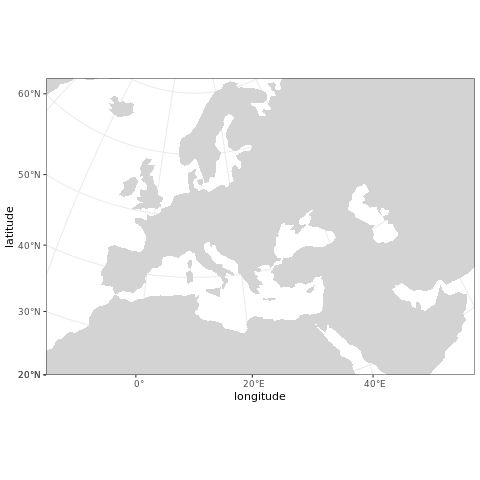

In [6]:
%%R
map <- world(xrange = c(-15, 60), yrange = c(20, 65),crs = "EPSG:3035")
print(map)
plot_map(map)

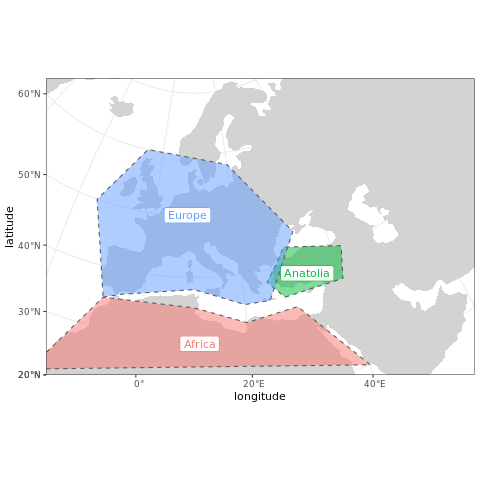

In [7]:
%%R

africa   <- region("Africa",   map, polygon = list(c(-18, 20), c(40, 20), c(30, 33),c(20, 32), c(10, 35), c(-8, 35)))
europe   <- region("Europe",   map, polygon = list(c(-8, 35), c(-5, 36), c(10, 38), c(20, 35), c(25, 35),c(33, 45), c(20, 58), c(-5, 60), c(-15, 50)))
anatolia <- region("Anatolia", map, polygon = list(c(28, 35), c(40, 35), c(42, 40), c(30, 43), c(27, 40), c(25, 38)))

plot_map(africa, europe, anatolia)

[<img src="arrow.png" width="100" style="float: left;">](#Home) &nbsp;

&nbsp;

<a name="Pop"></a>
### B. Setup populations, their demographic history and admixtures


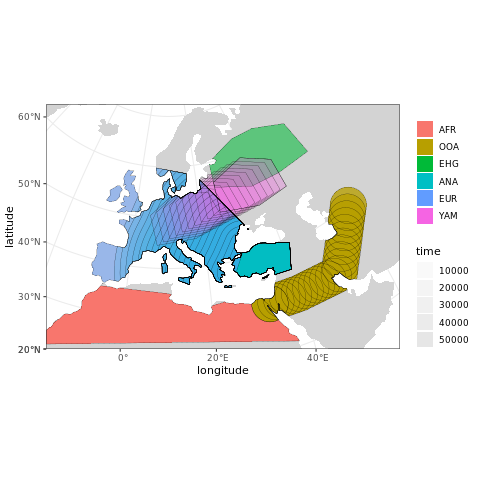

In [8]:
%%R

# African ancestral population
# ----------------------------

afr <- population("AFR", parent = "ancestor", time = 52000, N = 3000, map = map, polygon = africa)

# population of the first migrants out of Africa
# ----------------------------------------------

ooa <- population("OOA", parent = afr, time = 51000, N = 500, remove = 25000, center = c(33, 30), radius = 400e3) %>%
            move(trajectory = list(c(40, 30), c(50, 30), c(60, 40)), start = 50000, end = 40000, snapshots = 20)

# Eastern hunter-gatherers
# ------------------------    
    
ehg <- population("EHG", parent = ooa, time = 28000, N = 1000, remove = 6000, polygon = list(c(26, 55), c(38, 53), c(48, 53), c(60, 53), c(60, 60), c(48, 63), c(38, 63), c(26, 60)))

# European population
# -------------------

eur <- population( name = "EUR", parent = ehg, time = 25000, N = 2000, polygon = europe)

# Anatolian farmers
# -----------------

ana <- population( name = "ANA", time = 28000, N = 3000, parent = ooa, remove = 4000, center = c(34, 38), radius = 500e3, polygon = anatolia) %>%
        expand_range(by = 2500e3, start = 10000, end = 7000, polygon = join(europe, anatolia), snapshots = 20)

# Yamnaya steppe population
# -------------------------
    
yam <- population( name = "YAM", time = 7000, N = 500, parent = ehg, remove = 2500, polygon = list(c(26, 50), c(38, 49), c(48, 50), c(48, 56), c(38, 59), c(26, 56))) %>%
            move(trajectory = list(c(15, 50)), start = 5000, end = 3000, snapshots = 10)

# Gene flow events
# ----------------
    
gf <- list(
  gene_flow(from = ana, to = yam, rate = 0.5,  start = 6500, end = 6400, overlap = FALSE),
  gene_flow(from = ana, to = eur, rate = 0.5,  start = 8000, end = 6000),
  gene_flow(from = yam, to = eur, rate = 0.75, start = 4000, end = 3000)
)
    
plot_map(afr, ooa, ehg, eur, ana, yam)



[<img src="arrow.png" width="100" style="float: left;">](#Home) &nbsp;

&nbsp;

<a name="Com"></a>
### C. Compile the model

In [1]:
%%bash

mkdir -p /projects/racimolab/people/qxz396/spaceNNtime/data/europe

In [10]:
%%R

if(file.exists(paste(simulation_path, "/populations.tsv", sep = "" ))){
    model <- read_model(simulation_path)
}else{
    model <- compile_model(
      populations      = list(afr, ooa, ehg, eur, ana, yam), 
      gene_flow        = gf,
      generation_time  = 30,
      resolution       = 10e3,                     # resolution in meters per pixel
      competition      = 130e3, mating = 100e3,    # spatial interaction in SLiM
      dispersal        = 70e3,                     # how far will offspring end up from their parents
      path             = simulation_path, 
      overwrite        = TRUE
    )
}

model

slendr 'model' object 
--------------------- 
populations: AFR, OOA, EHG, ANA, EUR, YAM 
geneflow events: [no geneflow]
generation time: 30 
time direction: backward 
total running length: 52000 model time units
model type: spatial
  - number of spatial maps: 60 
  - resolution: 10000 distance units per pixel

configuration files in: /maps/projects/racimolab/people/qxz396/spaceNNtime/data/europe 


[<img src="arrow.png" width="100" style="float: left;">](#Home) &nbsp;

&nbsp;

<a name="Exp"></a>
### D. Explore the model

The command below `explore()` would by default open a browser. However, I added an otpion (`launchbrowser`) so that this can be prevented and istead, a link is provided (`launchbrowser = FALSE`). We can connect to that link using an **ssh tunel**. To do that:

1. run `explore(model, launchbrowser = FALSE)` in R. You will obtain a similar output than the cell below.

2. The http link has been provided. We can create a ssh tunel to connect to it by running the follwing command in a terminal in our local computer.

3. Check that the ports (numbers surrounding the "localhost" and the last digits in the link) should be the same.
4. Pate `localhost:7878` in a web browser
5. The `explore()` command can't be stopped if it's run with the `launchbrowser = FALSE` option. So, consider if you want to restart the kernel before running that function.

In [11]:
%%R

#explore(model, launchbrowser = FALSE)

NULL


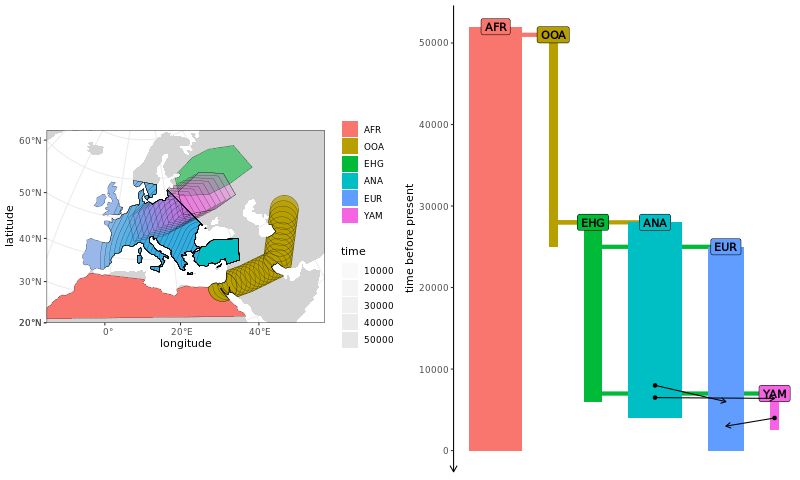

In [12]:
%%R -w 800
plot_grid(
    plot_map(afr, ooa, ehg, eur, ana, yam),
    plot_model(model) + ggplot2::theme(legend.position = "none"))

[<img src="arrow.png" width="100" style="float: left;">](#Home) &nbsp;

&nbsp;

<a name="Sam"></a>
### E. Sampling 

Through slendr, I'll schedule a uniform random sampling of indiviudals through time that will amount to 3,000 individuals. From this initial simulation, I'll downsample, alter the sampling strategy (exponentially random sampling) and other perturbations of the simulation to test the neural network in later steps of the pipeline.

In [11]:
%%R

set.seed(1234)

pops_list  <- list(afr, ooa, ehg, eur, ana, yam)

pop_timing <- data.frame(pop   = c("AFR", "OOA", "EHG", "EUR", "ANA", "YAM"),
                         start = c(52000, 51000, 28000, 25000, 28000,  7000),
                         end   = c(    0, 25000,  6000,     0,  4000,  2500),
                         index = c(    1,     2,     3,     4,     5,     6)) %>%
                        dplyr::filter(pop != "AFR")

if(! file.exists(paste(simulation_path, "/input_slim_sampling.tsv", sep = ""))){
    print("File does not exist, creating sampling dataframe")
    samples    <- sampling_uniform_intime(15000, pop_timing, pops_list)
    write.table(samples, file = paste(simulation_path, "/input_slim_sampling.tsv", sep = ""), quote=FALSE, col.names=TRUE)
}else{
    print("File exist, reading...")
    samples    <- read.table(paste(simulation_path, "/input_slim_sampling.tsv", sep = ""), header = T)
}
head(samples)

[1] "File exist, reading..."
   time pop n y_orig x_orig  y  x
1  6242 YAM 1     NA     NA NA NA
2 31268 OOA 1     NA     NA NA NA
3 43976 OOA 1     NA     NA NA NA
4   980 EUR 1     NA     NA NA NA
5 34137 OOA 1     NA     NA NA NA
6 35526 OOA 1     NA     NA NA NA


In [14]:
%%R

samples %>% dplyr::summarize(sum(n))

  sum(n)
1  15000


In [15]:
%%R

samples %>% summary()

      time           pop                  n        y_orig         x_orig       
 Min.   :  502   Length:13639       Min.   :1.0   Mode:logical   Mode:logical  
 1st Qu.:12884   Class :character   1st Qu.:1.0   NA's:13639     NA's:13639    
 Median :24883   Mode  :character   Median :1.0                                
 Mean   :25308                      Mean   :1.1                                
 3rd Qu.:37718                      3rd Qu.:1.0                                
 Max.   :50959                      Max.   :4.0                                
    y              x          
 Mode:logical   Mode:logical  
 NA's:13639     NA's:13639    
                              
                              
                              
                              


In [16]:
%%R

set.seed(1234)

pops_list  <- list(afr, ooa, ehg, eur, ana, yam)

pop_timing <- data.frame(pop   = c("AFR", "OOA", "EHG", "EUR", "ANA", "YAM"),
                         start = c(52000, 51000, 28000, 25000, 28000,  7000),
                         end   = c(    0, 25000,  6000,     0,  4000,  2500),
                         index = c(    1,     2,     3,     4,     5,     6)) %>%
                        dplyr::filter(pop != "AFR")

if(! file.exists(paste(simulation_path, "/input_slim_sampling_subset.tsv", sep = ""))){
    print("File does not exist, creating sampling dataframe")
    samples_subset    <- sampling_uniform_intime(1500, pop_timing, pops_list)
    write.table(samples, file = paste(simulation_path, "/input_slim_sampling_subset.tsv", sep = ""), quote=FALSE, col.names=TRUE)
}else{
    print("File exist, reading...")
    samples_subset    <- read.table(paste(simulation_path, "/input_slim_sampling_subset.tsv", sep = ""), header = T)
}
head(samples_subset)

[1] "File exist, reading..."
   time pop n y_orig x_orig  y  x
1  6242 YAM 1     NA     NA NA NA
2 31268 OOA 1     NA     NA NA NA
3 43976 OOA 1     NA     NA NA NA
4   980 EUR 1     NA     NA NA NA
5 34137 OOA 1     NA     NA NA NA
6 35526 OOA 1     NA     NA NA NA


In [17]:
%%R

gg_color_hue <- function(n) {
  hues = seq(15, 375, length = n + 1)
  hcl(h = hues, l = 65, c = 100)[1:n]
}

colors = gg_color_hue(6)
col_pop = c("AFR" = colors[1], "OOA" = colors[2], "EHG" = colors[3],
            "ANA" = colors[4], "EUR" = colors[5], "YAM" = colors[6])


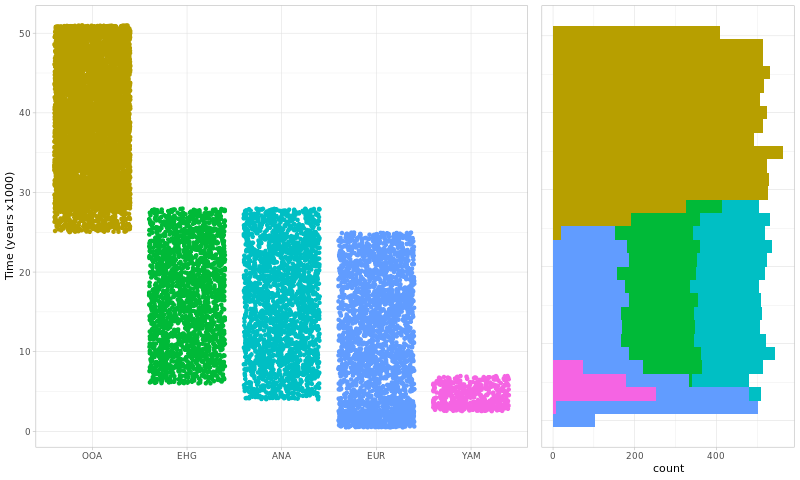

In [18]:
%%R -w 800

plot_grid(

    samples_subset %>%
        tidyr::uncount(n) %>%
        dplyr::mutate(pop = factor(pop, levels = c("OOA", "EHG", "ANA", "EUR", "YAM"))) %>%
        ggplot() +
        geom_jitter(aes(x = pop, y = time/1000, color = pop)) +
        scale_color_manual(values=col_pop) +
        xlab("") +
        ylab("Time (years x1000)") +
        theme_light() +
        theme(legend.position = "none"),
  
    samples_subset %>%
        tidyr::uncount(n) %>%
        ggplot() +
        geom_histogram(aes(y = time, fill = pop), bins = 30) +
        theme_light() +
        scale_fill_manual(values=col_pop) +
        theme(axis.ticks.y = element_blank(), axis.title.y = element_blank(), axis.text.y= element_blank(), legend.position = "none"),

    rel_widths= c(2, 1)) 

In [19]:
%%R

#ggsave("../sandbox/europe/plots/samp.pdf", width = 4, height = 3, dpi = 300, units = "in")

NULL


[<img src="arrow.png" width="100" style="float: left;">](#Home) &nbsp;

&nbsp;

<a name="Sim"></a>
### F. Simulate 

In [22]:
%%R

if(file.exists(paste(simulation_path, "/output_slim.trees", sep = ""))){
    print("Simulations already done!")
}else{
    slim(
      model,
      sequence_length    = 1e6, 
      recombination_rate = 1e-8, # simulate only a single locus
      sampling           = samples, 
      verbose            = TRUE, 
      #ts_recording = TRUE,
      save_locations     = TRUE, # save the location of everyone who ever lived
      save_sampling      = TRUE,
      method             = "batch", # change to "gui" to execute the model in SLiMgui
      random_seed        = 1234
    )
}

--------------------------------------------------
SLiM command to be executed:

slim  \
    -d SEED=1234  \
    -d 'SAMPLES="/maps/projects/racimolab/people/qxz396/spaceNNtime/data/europe/output_slim_sampling.tsv"' \
    -d 'MODEL="/maps/projects/racimolab/people/qxz396/spaceNNtime/data/europe"' \
    -d 'OUTPUT="/maps/projects/racimolab/people/qxz396/spaceNNtime/data/europe/output"' \
    -d SPATIAL=T \
    -d SEQUENCE_LENGTH=1000000 \
    -d RECOMB_RATE=1e-08 \
    -d BURNIN_LENGTH=0 \
    -d SIMULATION_LENGTH=1733 \
    -d SAVE_LOCATIONS=T \
    -d COALESCENT_ONLY=T \
    -d MAX_ATTEMPTS=1 \
    /maps/projects/racimolab/people/qxz396/spaceNNtime/data/europe/script.slim 
--------------------------------------------------

// Initial random seed:
40358992303293

// RunInitializeCallbacks():
SEED: 1234
initializeSLiMOptions(keepPedigrees = T, dimensionality = 'xy');
initializeInteractionType(0, "xy", reciprocal=T, maxDistance=13);
initializeInteractionType(1, "xy", reciprocal=T, maxDi

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




Generation 450: sampling 1 individuals of OOA(p1)
Generation 450: sampling 2 individuals of OOA(p1)
Generation 450: sampling 1 individuals of OOA(p1)
Generation 450: sampling 1 individuals of OOA(p1)
Generation 451: sampling 1 individuals of OOA(p1)
Generation 451: sampling 1 individuals of OOA(p1)
Generation 451: sampling 1 individuals of OOA(p1)
Generation 451: sampling 1 individuals of OOA(p1)
Generation 451: sampling 1 individuals of OOA(p1)
Generation 451: sampling 2 individuals of OOA(p1)
Generation 452: sampling 1 individuals of OOA(p1)
Generation 452: sampling 2 individuals of OOA(p1)
Generation 452: sampling 1 individuals of OOA(p1)
Generation 452: sampling 1 individuals of OOA(p1)
Generation 452: sampling 2 individuals of OOA(p1)
Generation 452: sampling 1 individuals of OOA(p1)
Generation 452: sampling 1 individuals of OOA(p1)
Generation 452: sampling 1 individuals of OOA(p1)
Generation 452: sampling 1 individuals of OOA(p1)
Generation 453: sampling 1 individuals of OOA(p1)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




Generation 860: sampling 1 individuals of EHG(p2)
Generation 860: sampling 1 individuals of EHG(p2)
Generation 860: sampling 1 individuals of EHG(p2)
Generation 860: sampling 1 individuals of EHG(p2)
Generation 860: sampling 1 individuals of EHG(p2)
Generation 860: sampling 1 individuals of EHG(p2)
Generation 861: sampling 1 individuals of ANA(p3)
Generation 861: sampling 1 individuals of EHG(p2)
Generation 861: sampling 1 individuals of OOA(p1)
Generation 861: sampling 1 individuals of EHG(p2)
Generation 861: sampling 1 individuals of OOA(p1)
Generation 861: sampling 1 individuals of EHG(p2)
Generation 861: sampling 1 individuals of OOA(p1)
Generation 861: sampling 1 individuals of ANA(p3)
Generation 861: sampling 1 individuals of EHG(p2)
Generation 861: sampling 1 individuals of EHG(p2)
Generation 861: sampling 1 individuals of EHG(p2)
Generation 861: sampling 1 individuals of OOA(p1)
Generation 862: sampling 1 individuals of EHG(p2)
Generation 862: sampling 1 individuals of EHG(p2)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




Generation 1244: sampling 1 individuals of EHG(p2)
Generation 1244: sampling 2 individuals of EHG(p2)
Generation 1244: sampling 1 individuals of ANA(p3)
Generation 1244: sampling 1 individuals of ANA(p3)
Generation 1244: sampling 1 individuals of EUR(p4)
Generation 1244: sampling 1 individuals of EHG(p2)
Generation 1244: sampling 1 individuals of EUR(p4)
Generation 1244: sampling 1 individuals of ANA(p3)
Generation 1245: sampling 1 individuals of EHG(p2)
Generation 1245: sampling 1 individuals of EHG(p2)
Generation 1245: sampling 1 individuals of EHG(p2)
Generation 1245: sampling 1 individuals of EUR(p4)
Generation 1245: sampling 1 individuals of EHG(p2)
Generation 1245: sampling 1 individuals of ANA(p3)
Generation 1245: sampling 1 individuals of EHG(p2)
Generation 1245: sampling 1 individuals of EUR(p4)
Generation 1245: sampling 1 individuals of EUR(p4)
Generation 1245: sampling 1 individuals of EUR(p4)
Generation 1245: sampling 2 individuals of EUR(p4)
Generation 1245: sampling 1 in

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Generation 1629: sampling 1 individuals of EUR(p4)
Generation 1629: sampling 1 individuals of YAM(p5)
Generation 1629: sampling 1 individuals of YAM(p5)
Generation 1629: sampling 1 individuals of YAM(p5)
Generation 1629: sampling 1 individuals of EUR(p4)
Generation 1629: sampling 1 individuals of EUR(p4)
Generation 1629: sampling 1 individuals of YAM(p5)
Generation 1629: sampling 1 individuals of EUR(p4)
Generation 1629: sampling 1 individuals of EUR(p4)
Generation 1630: sampling 1 individuals of EUR(p4)
Generation 1630: sampling 1 individuals of YAM(p5)
Generation 1630: sampling 1 individuals of YAM(p5)
Generation 1630: sampling 1 individuals of YAM(p5)
Generation 1630: sampling 1 individuals of YAM(p5)
Generation 1630: sampling 1 individuals of YAM(p5)
Generation 1630: sampling 1 individuals of EUR(p4)
Generation 1630: sampling 1 individuals of YAM(p5)
Generation 1631: sampling 1 individuals of YAM(p5)
Generation 1631: sampling 1 individuals of EUR(p4)
Generation 1631: sampling 1 ind

In [44]:
%%R

#This was created with a simulation with N = 1500 instead of N = 15000. 

#if(!file.exists(paste(simulation_path, "sim.gif", sep = ""))){
#    animate_model(model = model, steps = 100, width = 500, height = 300, gif = paste(simulation_path, "sim.gif", sep = ""))
#}

NULL


![](../data/europe/sim.gif "gif")

[<img src="arrow.png" width="100" style="float: left;">](#Home) &nbsp;

&nbsp;